In [1]:
from scripts.classes import *
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.cluster import KMeans

b_neurons = [
    'AVAR',
    'AVAL',
    'SMDVR',
    'SMDVL',
    'SMDDR',
    'SMDDL',
    'RIBR',
    'RIBL'
]


In [2]:
all_models = []
xredall = []

for i in range(5):
    data = Database(i, verbose=0)
    data.exclude_neurons(b_neurons)

    # select data set
    x = np.asarray(data.neuron_traces.T)
    y = data.B

    base_model = LogisticRegression(solver='lbfgs', multi_class='multinomial', max_iter=1000)
    model = base_model.fit(x, y)
    y_pred = model.predict(x)


    accuracy = accuracy_score(y, y_pred)
    all_models.append(model)
    xredall.append(x)
    print("Accuracy:", accuracy)

6 neurons have been removed.
Accuracy: 0.8979917118265859
8 neurons have been removed.
Accuracy: 0.9010848755583918
8 neurons have been removed.
Accuracy: 0.9297155933311539
6 neurons have been removed.
Accuracy: 0.9447296889157354
8 neurons have been removed.
Accuracy: 0.9116186693147964


In [3]:
# Get probabilities for cog-states
ypall = []
Wall = []

for idx in range(5):
    # get model and neuron traces
    model = all_models[idx]
    xred = xredall[idx]
    # get probabilities and weights
    yp = model.predict_proba(xred)
    W = model.coef_.T
    print(yp.shape, W.shape)

    ypall.append(yp)
    Wall.append(W)
  

(3137, 8) (103, 8)
(3134, 8) (127, 8)
(3059, 8) (123, 8)
(3311, 8) (119, 8)
(3021, 8) (121, 8)


In [6]:
nsets = 5
nrep = 10
max_clusters = 20
p_markov = np.zeros((max_clusters, nrep, 5))
xcall = []

print(p_markov.shape)

for nset in range(nsets):
    print('ypall shape:', ypall[nset].shape)
    M = ypall[nset].shape[0]
    xc = np.zeros((M, max_clusters, nrep))
    
    for reps in range(nrep):
        print("Set ", nset, " repetition ", reps)
        
        for nrclusters in range(max_clusters):
            # k-means
            clusters = KMeans(n_clusters=nrclusters+1, random_state=0, n_init="auto").fit(ypall[nset])
            xctmp = clusters.labels_
            print(len(xctmp), xctmp)
            
            p, _ = markovian(xctmp, K=200)
            p_markov[nrclusters, reps, nset] = p
            xc[:, nrclusters, reps] = xctmp
        
    xcall.append(xc)
            


(20, 10, 5)
ypall shape: (3137, 8)
Set  0  repetition  0
3137 [0 0 0 ... 0 0 0]
3137 [1 1 1 ... 1 1 1]
3137 [1 1 2 ... 2 2 2]
3137 [1 1 2 ... 2 2 2]
3137 [1 1 2 ... 2 2 2]
3137 [2 2 2 ... 5 5 5]
3137 [2 2 2 ... 5 5 5]
3137 [6 6 6 ... 7 7 7]
3137 [6 6 7 ... 7 7 7]
3137 [6 6 7 ... 7 7 7]
3137 [6 6 7 ... 7 7 7]
3137 [6 6 6 ... 7 7 7]
3137 [ 6  6 12 ...  7  7 12]
3137 [13 13  6 ... 12  7 12]
3137 [13 13  6 ... 12  7 12]
3137 [13 13  6 ... 12  7 12]
3137 [13 13  6 ... 12  7 12]
3137 [13 13  6 ... 12  7 12]
3137 [13 13  6 ... 12  7 12]
3137 [ 6  6 19 ... 12 12 12]
Set  0  repetition  1
3137 [0 0 0 ... 0 0 0]
3137 [1 1 1 ... 1 1 1]
3137 [1 1 2 ... 2 2 2]
3137 [1 1 2 ... 2 2 2]
3137 [1 1 2 ... 2 2 2]
3137 [2 2 2 ... 5 5 5]
3137 [2 2 2 ... 5 5 5]
3137 [6 6 6 ... 7 7 7]
3137 [6 6 7 ... 7 7 7]
3137 [6 6 7 ... 7 7 7]
3137 [6 6 7 ... 7 7 7]
3137 [6 6 6 ... 7 7 7]
3137 [ 6  6 12 ...  7  7 12]
3137 [13 13  6 ... 12  7 12]
3137 [13 13  6 ... 12  7 12]
3137 [13 13  6 ... 12  7 12]
3137 [13 13  6 ... 12

(20, 10, 5)
(10, 20)
(10, 20)
(10, 20)
(10, 20)
(10, 20)


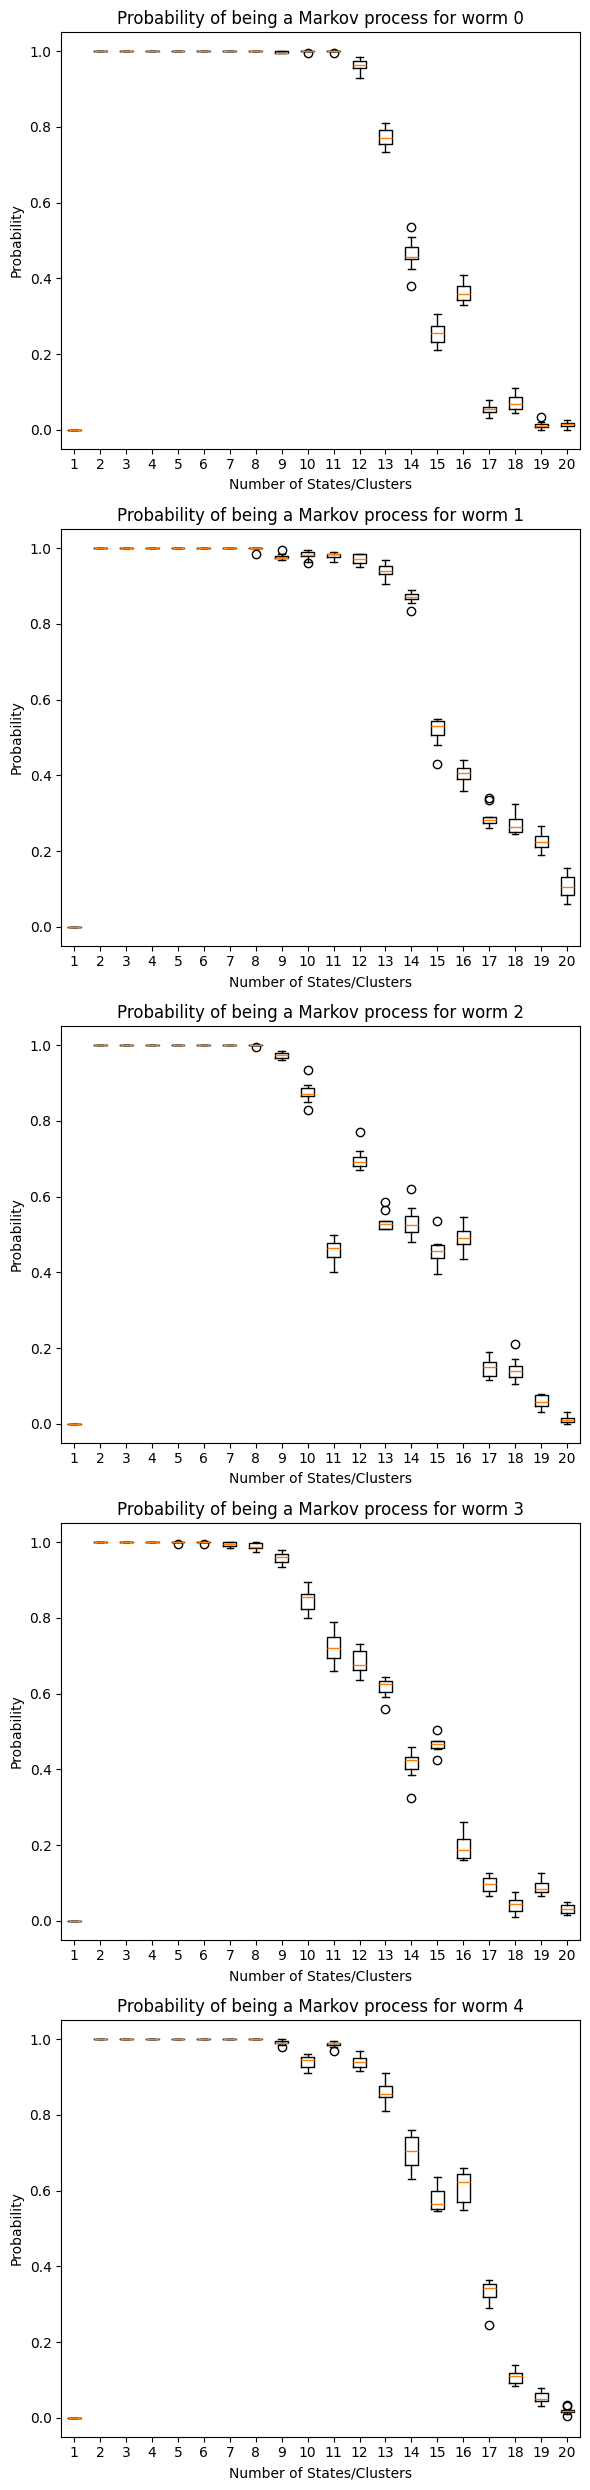

In [7]:
print(p_markov.shape)
worms = 5
fig, axes = plt.subplots(nrows=worms, ncols=1, figsize=(6, 25))

for idx, ax in enumerate(axes):

    data = p_markov[:,:,idx].T
    print(data.shape)
    # Create boxplots
    ax.boxplot(data)
    ax.set_title(f'Probability of being a Markov process for worm {idx}')
    ax.set_xlabel('Number of States/Clusters')
    ax.set_ylabel('Probability')

# Adjust layout to prevent overlapping
plt.tight_layout()
plt.show()

In [9]:
print(p_markov.shape)
plot_markov = np.mean(p_markov, axis=1)
print(plot_markov.shape)


(20, 10, 5)
(20, 5)


(20, 10, 5)


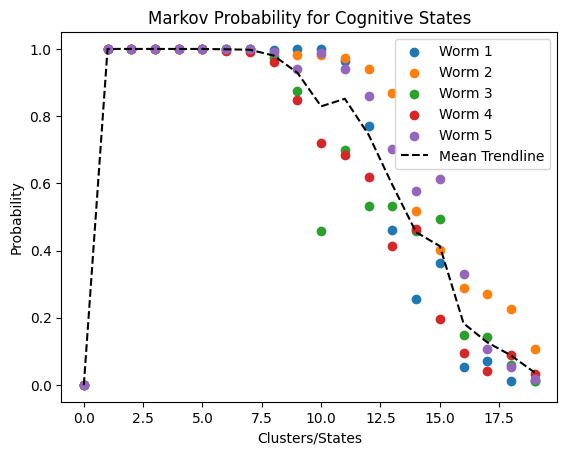

In [16]:
print(p_markov.shape)
plot_markov = np.mean(p_markov, axis=1).T
worms = 5


# Scatter plot each row with the index as x-values and the values as y-values
for i in range(plot_markov.shape[0]):
    plt.scatter(np.arange(plot_markov.shape[1]), plot_markov[i], label=f'Worm {i + 1}')

mean_trendline = np.mean(plot_markov, axis=0)
plt.plot(np.arange(plot_markov.shape[1]), mean_trendline, color='black', linestyle='--', label='Mean Trendline')

# Add labels and legend
plt.xlabel('Clusters/States')
plt.ylabel('Probability')
plt.title('Markov Probability for Cognitive States')
plt.legend()

# Show the plot
plt.show()

In [4]:
z, _ = simulate_markovian(M=100, N=5)
print(z)
p, P = markovian(z, K=200)
print(p)
print(P)

[2 2 2 4 0 3 1 3 0 0 0 1 3 3 3 1 0 0 1 1 1 1 1 2 0 1 3 1 3 1 1 1 0 1 1 1 0
 0 0 4 2 4 1 3 1 3 4 1 3 4 1 1 0 0 1 4 1 0 1 1 0 1 1 3 1 1 1 3 1 1 1 1 1 4
 2 4 3 3 1 1 1 4 0 1 4 1 1 3 3 1 1 4 3 3 3 1 3 1 3 1]
0.905
[[0.375      0.5        0.         0.0625     0.0625    ]
 [0.13333333 0.46666667 0.02222222 0.26666667 0.11111111]
 [0.2        0.         0.2        0.         0.6       ]
 [0.04761905 0.57142857 0.         0.28571429 0.0952381 ]
 [0.18181818 0.45454545 0.18181818 0.18181818 0.        ]]


In [1]:
### SAVING DATA WITH PICKLE ###

In [1]:
import pickle
from scripts.classes import *
b_neurons = [
    'AVAR',
    'AVAL',
    'SMDVR',
    'SMDVL',
    'SMDDR',
    'SMDDL',
    'RIBR',
    'RIBL'
]


6 neurons have been removed.
Accuracy: 0.8979917118265859
Testing markovianity - repetition  1
Testing markovianity - repetition  2
8 neurons have been removed.
Accuracy: 0.9010848755583918
Testing markovianity - repetition  1
Testing markovianity - repetition  2
8 neurons have been removed.
Accuracy: 0.9297155933311539
Testing markovianity - repetition  1
Testing markovianity - repetition  2
6 neurons have been removed.
Accuracy: 0.9447296889157354
Testing markovianity - repetition  1
Testing markovianity - repetition  2
8 neurons have been removed.
Accuracy: 0.9116186693147964
Testing markovianity - repetition  1
Testing markovianity - repetition  2


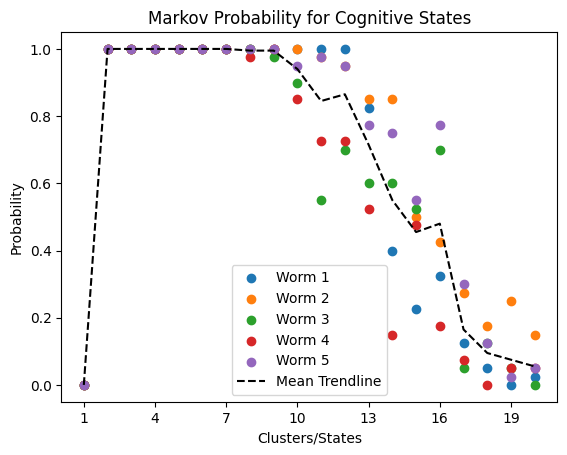

In [2]:
n_reps = 2
n_clusters = 20
n_worms = 5
p_m = np.zeros((n_clusters, n_reps, n_worms))

for i in range(n_worms):
    data = Database(data_set_no=i)
    data.exclude_neurons(b_neurons)

    logreg = LogisticRegression(solver='lbfgs', multi_class='multinomial', max_iter=1000)

    data.fit_model(logreg, markov_test=True, nrep=n_reps, max_clusters=n_clusters, sim_markov=20)
    p_m[:, :, i] = data.p_markov
    
    with open(f'data/pickles/data_worm_{i+1}.pkl', 'wb') as file:
        pickle.dump(data, file)

plot_markov = np.mean(p_m, axis=1).T

average_markov_plot(plot_markov)


(2, 20)


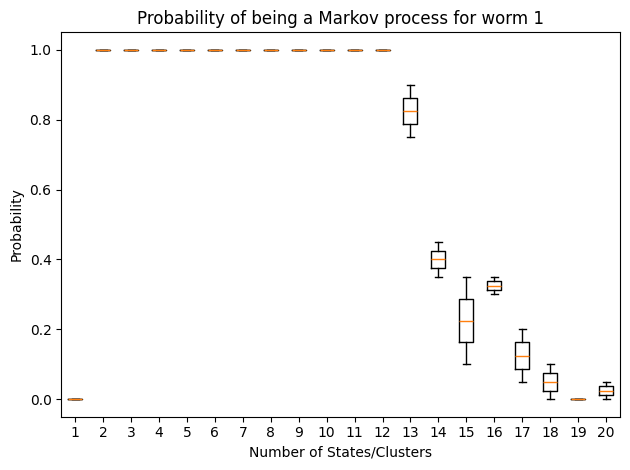

(2, 20)


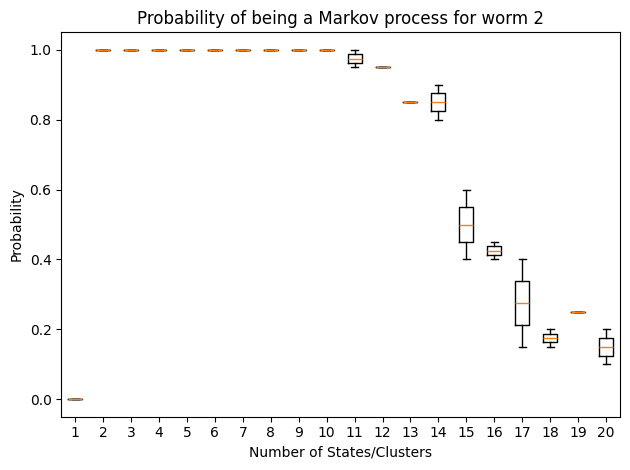

(2, 20)


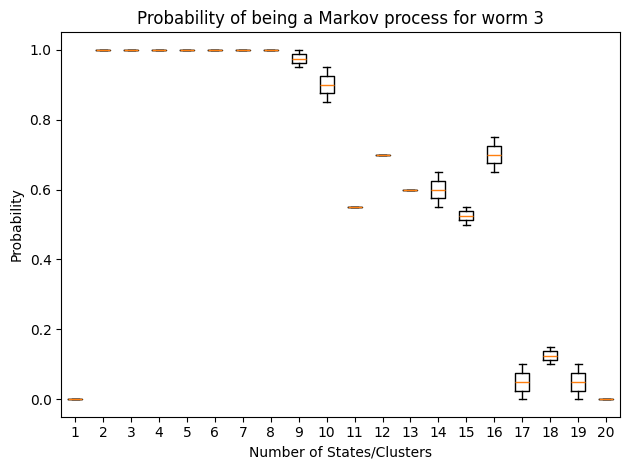

(2, 20)


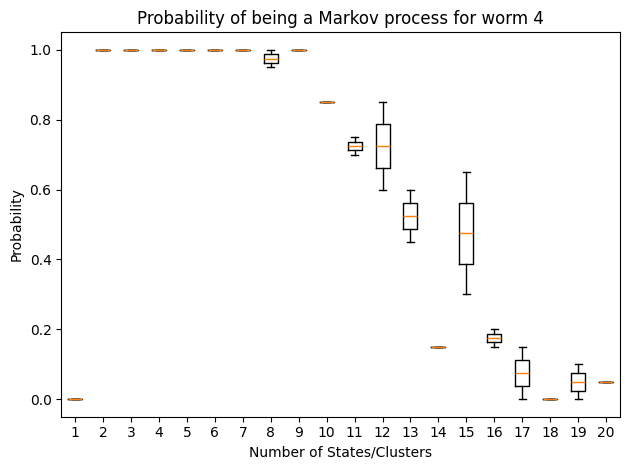

(2, 20)


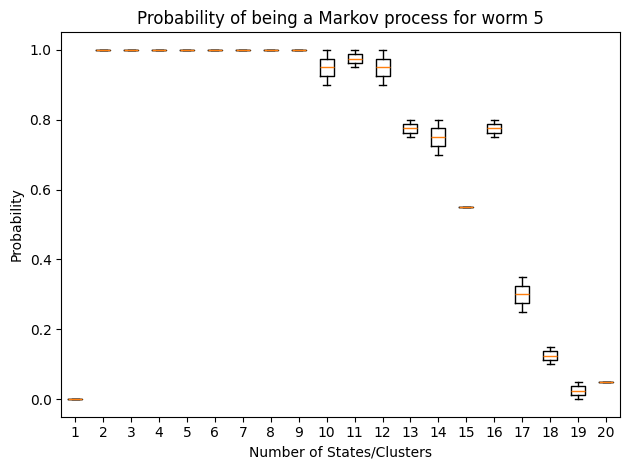

In [6]:
# Load the pickled data back into a Python object
for i in range(5):
    with open(f'data/pickles/data_worm_{i+1}.pkl', 'rb') as file:
        loaded_data = pickle.load(file)
        
    loaded_data.plot_markov()